# Forward Simulation of UXO Detection

In [ ]:
import os
import pickle
import numpy as np
from forward_freq_survey import Forward_Freq_Survey
from layered_earth import Layered_Earth
from UXO_object import UXO_Object

C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define System Parameters

In [2]:
z0 = 0.1 # height of our sensor above the ground (m)
moment = 1 # dipole moment in A*m^2
coil_spacing = 1 # spacing between Rx and Tx coils (m)
min_freq = 1e4 # minimum frequency (Hz)
max_freq = 1e5 # maximum frequency (Hz)
num_freqs = 5 # number of frequencies to use in simulation
soil_conductivity = 0.01 # conductivity of the soil (S/m)
uxo_conductivity = 1e5 # conductivity of the UXO (S/m)

## Define Simulated Data and x,y Grid

In [3]:
# define frequencies
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_freqs)

# define UXO parameters
length = 15 # length of the UXO (cm)
diameter = 5 # diameter of the UXO (cm)

# create uxo object
uxo = UXO_Object(np.array([0.0, 0.0, -1.0]), length/100, diameter/100, 0, 0, uxo_conductivity)

# create layered earth object
earth = Layered_Earth(soil_conductivity, uxo)

# define x,y grid
min_dist = -1
max_dist = 1
n_points = 10
x_vals = np.linspace(min_dist, max_dist, n_points)
y_vals = np.linspace(min_dist, max_dist, n_points)

# define the forward simulation object
sim = Forward_Freq_Survey(frequencies, z0, moment, coil_spacing)

## Run the simulation and save the data

In [ ]:
# get predicted data at each xy point
data_list = []
for x in x_vals:
    for y in y_vals:
        # get predicted data
        dpred = sim.predict_data(*earth.layers_at_pt((x, y)))
        # add noise to the data
        noise = (
            0.05
            * np.abs(dpred)
            * np.random.normal(size=len(dpred))
        )
        dpred_out = dpred + noise
        # store the data in a dictionary
        data_dict = {"x": x,
                     "y": y,
                     "frequencies": frequencies,
                     "hz_real": dpred_out[0::2],
                     "hz_imag": dpred_out[1::2]}
        data_list.append(data_dict)
# write data to file
os.makedirs("../forward_data", exist_ok=True)
with open("../forward_data/forward_simulation_data_test0.pkl", "wb") as f:
    pickle.dump((data_list, earth), f)

## Plot the Data
Todo: make this work with the new data structure

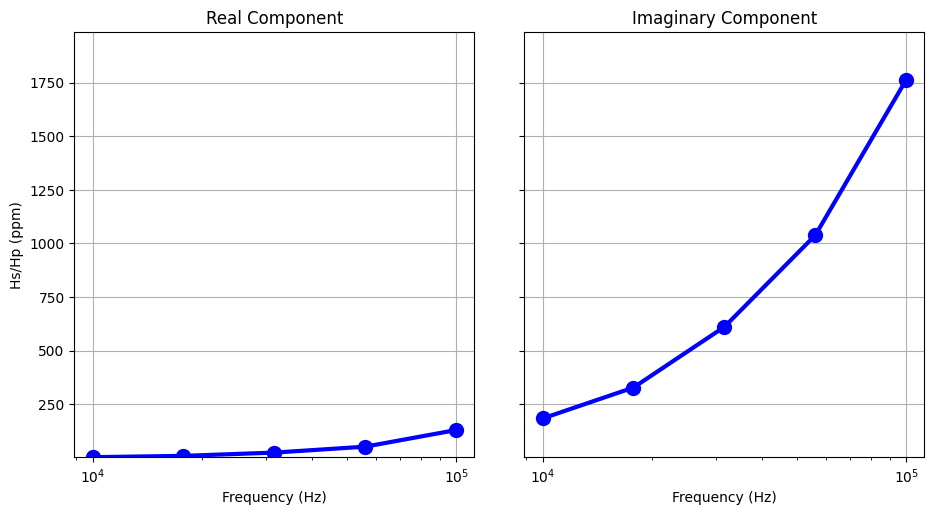

In [5]:
import matplotlib.pyplot as plt

data = data_list[12]

ylim = [np.min(dpred), 1.1 * np.max(dpred)]

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.85])
ax1.semilogx(frequencies, data['hz_real'], "b-o", lw=3, ms=10)
ax1.grid()
ax1.set_ylim(ylim)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Hs/Hp (ppm)")
ax1.set_title("Real Component")

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.semilogx(frequencies, data['hz_imag'], "b-o", lw=3, ms=10)
ax2.set_ylim(ylim)
ax2.grid()
ax2.set_xlabel("Frequency (Hz)")
ax2.set_yticklabels("")
ax2.set_title("Imaginary Component")

plt.show()

# Simulate Many Data Sets

In [17]:
# physical constants
z0 = 0.1 # height of our sensor above the ground (m)
moment = 1 # dipole moment in A*m^2
coil_spacing = 1 # spacing between Rx and Tx coils (m)
min_freq = 1e4 # minimum frequency (Hz)
max_freq = 1e5 # maximum frequency (Hz)
num_freqs = 5 # number of frequencies to use in simulation

# define frequencies
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_freqs)

# define measurement locations
min_dist = -0.25
max_dist = 0.25
n_points = 10
x_vals = np.linspace(min_dist, max_dist, n_points)
y_vals = np.linspace(min_dist, max_dist, n_points)

In [18]:
# define random samples for data
n_samples = 100

uxo_lengths = np.random.uniform(5, 15, n_samples)
uxo_diameters = np.random.uniform(0.15, 0.75, n_samples) * uxo_lengths
uxo_conductivities = np.random.uniform(1e4, 1e6, n_samples)
soil_conductivities = np.random.uniform(0.01, 0.1, n_samples)
noise_levels = np.random.uniform(0.01, 0.1, n_samples)
strikes = np.random.uniform(0, 2*np.pi, n_samples)
dips = np.random.uniform(0, np.pi, n_samples)
uxo_depth = np.random.uniform(0.5, 1.5, n_samples)
xy_locs = np.random.uniform(min_dist, max_dist, (n_samples, 2))

In [19]:
for i in range (n_samples):
    # unpack parameters
    length = uxo_lengths[i]
    diameter = uxo_diameters[i]
    uxo_conductivity = uxo_conductivities[i]
    soil_conductivity = soil_conductivities[i]
    noise_level = noise_levels[i]
    strike = strikes[i]
    dip = dips[i]
    uxo_center = np.array([*xy_locs[i], -uxo_depth[i]])

    # create uxo object
    uxo = UXO_Object(uxo_center, length/100, diameter/100, strike, dip, uxo_conductivity)

    # create layered earth object
    earth = Layered_Earth(soil_conductivity, uxo)

    # define the forward simulation object
    sim = Forward_Freq_Survey(frequencies, z0, moment, coil_spacing)

    # get predicted data at each xy point
    data_list = []
    for x in x_vals:
        for y in y_vals:
            # get predicted data
            dpred = sim.predict_data(*earth.layers_at_pt((x, y)))
            # add noise to the data
            noise = (
                noise_level
                * np.abs(dpred)
                * np.random.normal(size=len(dpred))
            )
            dpred_out = dpred + noise
            # store the data in a dictionary
            data_dict = {"x": x,
                        "y": y,
                        "frequencies": frequencies,
                        "hz_real": dpred_out[0::2],
                        "hz_imag": dpred_out[1::2]}
            data_list.append(data_dict)
    # write data to file
    os.makedirs("../forward_data/batch_simulation0", exist_ok=True)
    with open(f"../forward_data//batch_simulation0/forward_simulation_data_{i}.pkl", "wb") as f:
        pickle.dump((data_list, earth), f)